In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Printing/output settings

In [2]:
pd.set_option('display.max_colwidth', None)

# Explanatory Data Analysis

### Load data

We will load only positives reviews (rating > 3) from the database.

In [4]:
reviews = pd.read_sql(f"""
    SELECT podcast_id, author_id, rating, reviews.created_at , reviews.title, reviews.content 
    FROM reviews
    Where rating > 3
""", sqlite3.connect("initial_data/database.sqlite"))

podcast_w_category = pd.read_sql(f"""
    SELECT podcast_id, title as p_title, category
    FROM categories JOIN podcasts USING (podcast_id)
""", sqlite3.connect("initial_data/database.sqlite"))

Each podcast has multiple categories so we will concatenate them 
into a single string and will handle them as a single category for now.

In [5]:
# for each podcast, concatenate all categories once you sort them
podcast_w_category = podcast_w_category.groupby("podcast_id").agg({"p_title": "first", "category": lambda x: "#".join(sorted(x))}).reset_index()

# sort by aurhor_id, podcast_id and created_at
reviews = reviews.sort_values(by=['author_id', 'podcast_id', 'created_at'])

### Removing duplicates reviews
Users might review a podcast more than once. We keep only the latest review.

In [6]:
# check if there are any duplicates
duplicates = reviews.duplicated(subset=['author_id','podcast_id'], keep='last')
total_duplicates = duplicates.shape[0] - (duplicates.shape[0] - duplicates.sum())

# remove based on boolean mask
reviews = reviews[~duplicates]
print(f'Removed {total_duplicates} duplicates ~ {round(duplicates.sum()/duplicates.shape[0],3)}% of total reviews')

Removed 59619 duplicates ~ 0.033% of total reviews


### Removing reviews with podcast_id not in podcasts table
There are reviews that their podcast id is not in the podcast table so we do not have any info about them.

In [7]:
# get all podcast ids in podcast_w_category
pod_id_in_table = podcast_w_category['podcast_id'].unique()
# remove all author ids that are in reviews but not in podcast_w_category
before = reviews.shape[0]
reviews = reviews[reviews['podcast_id'].isin(pod_id_in_table)]
after = reviews.shape[0]
print(f'Removed {before - after} reviews ~ {round((before - after)/before,3)}% of total reviews')

Removed 21579 reviews ~ 0.012% of total reviews


### Keeping only authors with more than N reviews

In [8]:
# Keep only authors with at least K reviews
K = 5
reviews = reviews.groupby('author_id').filter(lambda x: len(x) >= K)

In [9]:
# print unique authors and reviews
print(f'Unique authors: {reviews["author_id"].unique().shape[0]}')
print(f'Unique reviews: {reviews.shape[0]}')

Unique authors: 18551
Unique reviews: 156646


### Creating the final dataset

In [10]:
# merge reviews with podcast_w_category
reviews_w_podcast_w_category = reviews.merge(podcast_w_category, on='podcast_id', how='inner')
# keep only the columns we need
reviews_w_podcast_w_category = reviews_w_podcast_w_category[['author_id', 'podcast_id', 'p_title', 'category', 'rating', 'created_at']]
reviews_w_podcast_w_category = reviews_w_podcast_w_category.sort_values(by=['author_id', 'created_at'], ascending=False)

In [ ]:
# clean memory
del  reviews
del podcast_w_category

In [ ]:
### We have 3 ideas for the clustering:
#  1. Cluster based on the average rating of the categories
#       We will represent each author as a vector of size 108 (at the total number of most frequent categories)
#       Each element of the vector will be the average rating of the author for the category
#       We will use KMeans to cluster the authors

#  2. Cluster based on the K most recent reviews
#       We will represent each author as a vector of size K, where each element is a podcast title
#       We will use KModes to cluster the authors
#  3. Cluster based on the K most recent reviews

#       We will represent each author as a vector of size K, where each element is a podcast category
#       We will use KModes to cluster the authors


### Clustering

In [16]:
def prepare_data_for_clustering(data, K):
    """
    data: dataframe with columns author_id, podcast_id, p_title, category, rating, created_at
    K: number of most recent reviews to consider
    """
    # get the K most recent reviews for each author
    data = data.groupby('author_id').head(K)
    authors = data['author_id'].unique()
    total_authors = authors.shape[0]
    print(f'Unique authors: {total_authors} with >={K} reviews')

    # get the most frequent categories
    category_freq = reviews_w_podcast_w_category['category'].str.split('#').explode().value_counts().to_dict()

    # For each podcast category split the concatenated string into a list of categories and keep the 
    # most frequent category as the category of the podcast
    data = data[['author_id', 'category', 'created_at']]
    data['category'] = data['category'].str.split('#').apply(lambda x: max(x, key=lambda y: category_freq[y]))
    

    # represent each author as a vector of K categories
    matrix_K_categories = pd.DataFrame(index=authors, columns=['category_' + str(i) for i in range(K)])
    matrix_K_categories = matrix_K_categories.fillna("empty")
    # fill the matrix with the average rating of the author for the podcast title in order
    for index, author in enumerate (authors):
        index = index + 1
        categories = data[data['author_id'] == author]['category'].values
        for i in range(K):
            matrix_K_categories.loc[author, 'category_' + str(i)] = categories[i]
        if index % 3000 == 0:
            print(f'{index} authors processed')    


    return matrix_K_categories

In [17]:
matrix_K_categories = prepare_data_for_clustering(reviews_w_podcast_w_category, 5)

Unique authors: 18551 with >=5 reviews
3000 authors processed
6000 authors processed
9000 authors processed
12000 authors processed
15000 authors processed
18000 authors processed


In [ ]:
def clustering(data, num_of_clusters, plot=False):
    # Categorical data clustering
    # Check source: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
    # Check source: https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7

    data = data.astype('str')

    from kmodes.kmodes import KModes
    import matplotlib.pyplot as plt
    import numpy as np

    centroids = None

    import time

    start_time = time.time()
    # create a KMeans instance with k clusters
    kmodes = KModes(n_clusters=num_of_clusters, init = 'random', verbose=0 , max_iter=100, n_jobs=1, random_state=42)
    # fit the model to the matrix
    kmodes.fit(data)
    end_time = time.time()
    # info about the clustering
    print(f"For K: {num_of_clusters} and init method random-> Max iterations: {kmodes.n_iter_}  Cost: {kmodes.cost_} Time: {round((end_time - start_time)/60,3)} minutes")
    # get centroids
    centroids = kmodes.cluster_centroids_
    #print(f"Centroids: {centroids}")
    # get labels
    data['cluster'] = kmodes.labels_

    return data, centroids


In [20]:
# Idea 3
# Each author is a datapoint with K features (podcast categories)
datapoints = reviews_w_podcast_w_category_k[['author_id', 'category', 'created_at', 'rating']]
datapoints['category'] = datapoints['category'].str.split('#').apply(lambda x: max(x, key=lambda y: category_freq[y]))
# populate the matrix
matrix_K_categories = pd.DataFrame(index=authors, columns=['category_' + str(i) for i in range(K)])
matrix_K_categories = matrix_K_categories.fillna("empty")
# fill the matrix with the average rating of the author for the podcast title in order
for index, author in enumerate (authors):
    index = index + 1
    categories = datapoints[datapoints['author_id'] == author]['category'].values
    for i in range(K):
        matrix_K_categories.loc[author, 'category_' + str(i)] = categories[i]
    if index % 3000 == 0:
        print(f'{index} authors processed')

C:\Users\staur\AppData\Local\Temp\ipykernel_20408\3989305834.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datapoints['category'] = datapoints['category'].str.split('#').apply(lambda x: max(x, key=lambda y: category_freq[y]))


3000 authors processed
6000 authors processed
9000 authors processed
12000 authors processed
15000 authors processed
18000 authors processed


In [21]:
print(matrix_K_categories.head())

                      category_0 category_1       category_2  category_3  \
FFF559CD2875885           comedy    tv-film  society-culture  true-crime   
FFF171657D896FA           comedy       arts           comedy      comedy   
FFEF1081D4828D2             news     sports      kids-family     tv-film   
FFEE0B290529BDE           sports     sports             news      sports   
FFE6F75290CFE09  society-culture    tv-film  society-culture     tv-film   

                            category_4  
FFF559CD2875885        society-culture  
FFF171657D896FA        society-culture  
FFEF1081D4828D2                science  
FFEE0B290529BDE  religion-spirituality  
FFE6F75290CFE09                tv-film  


(18551, 5)
For K: 2 and init method random-> Max iterations: 1  Cost: 64461.0 Time: 0.487 minutes
For K: 3 and init method random-> Max iterations: 2  Cost: 58311.0 Time: 0.59 minutes
For K: 4 and init method random-> Max iterations: 3  Cost: 55773.0 Time: 0.667 minutes
For K: 5 and init method random-> Max iterations: 3  Cost: 53449.0 Time: 0.647 minutes
For K: 6 and init method random-> Max iterations: 2  Cost: 52954.0 Time: 0.797 minutes
For K: 7 and init method random-> Max iterations: 4  Cost: 50984.0 Time: 0.78 minutes
For K: 8 and init method random-> Max iterations: 4  Cost: 50337.0 Time: 0.756 minutes
For K: 9 and init method random-> Max iterations: 2  Cost: 50220.0 Time: 0.8 minutes
For K: 10 and init method random-> Max iterations: 2  Cost: 49648.0 Time: 0.757 minutes
For K: 11 and init method random-> Max iterations: 2  Cost: 49128.0 Time: 0.72 minutes
For K: 12 and init method random-> Max iterations: 2  Cost: 48619.0 Time: 0.741 minutes
For K: 13 and init method random->

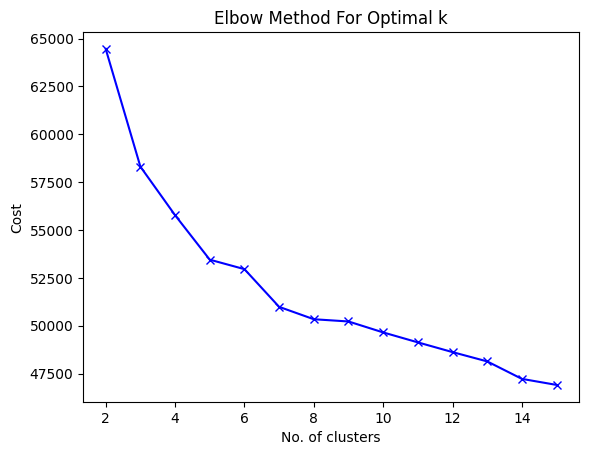

In [23]:
# Categorical data clustering
# Import the necessary packages

# Check source: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
# Check source: https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7
matrix_K_categories = matrix_K_categories.astype('str')
print(matrix_K_categories.shape)
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
import numpy as np

# create a list of K values
# K_clusters = list(range(2, 25))
# K_clusters.extend([30,35,40,50,60])
K_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# create a list of silhouette scores
cost = []
# create a df
cost_per_intial = pd.DataFrame(columns=['random', 'Cao', 'Huang'])
# loop over K values
import time
initials = ["random","Cao","Huang"]
for k in K_clusters:
    start_time = time.time()
    # create a KMeans instance with k clusters
    kmodes = KModes(n_clusters=k, init = 'random', verbose=0 , max_iter=100, n_jobs=1, random_state=42)
    # fit the model to the matrix
    kmodes.fit(matrix_K_categories)
    # get the cost
    cost.append(kmodes.cost_)
    # print max iterations of the algorithm
    end_time = time.time()
    print(f"For K: {k} and init method {initials[0]}-> Max iterations: {kmodes.n_iter_}  Cost: {kmodes.cost_} Time: {round((end_time - start_time)/60,3)} minutes")
    # get centroids
    #print(f"Centroids: {kmodes.cluster_centroids_}")

# plot the results
plt.plot(K_clusters, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:

start_time = time.time()
# create a KMeans instance with k clusters
kmodes = KModes(n_clusters=7, init = 'random', verbose=0 , max_iter=100, n_jobs=1, random_state=42)
# fit the model to the matrix
kmodes.fit(matrix_K_categories)
# get the cost
cost.append(kmodes.cost_)
# print max iterations of the algorithm
end_time = time.time()
print(f"For K: {7} and init method {initials[0]}-> Max iterations: {kmodes.n_iter_}  Cost: {kmodes.cost_} Time: {round((end_time - start_time)/60,3)} minutes")
# get centroids
#print(f"Centroids: {kmodes.cluster_centroids_}")

# Assign the cluster labels to the a temp matrix
matrix_K_categories['cluster'] = kmodes.labels_

For K: 7 and init method random-> Max iterations: 4  Cost: 50984.0 Time: 0.786 minutes


In [26]:
# count the number of datapoints in each cluster
matrix_K_categories['cluster'].value_counts()
matrix_K_categories.head()


,category_0,category_1,category_2,category_3,category_4,cluster
FFF559CD2875885,comedy,tv-film,society-culture,true-crime,society-culture,3
FFF171657D896FA,comedy,arts,comedy,comedy,society-culture,0
FFEF1081D4828D2,news,sports,kids-family,tv-film,science,1
FFEE0B290529BDE,sports,sports,news,sports,religion-spirituality,1
FFE6F75290CFE09,society-culture,tv-film,society-culture,tv-film,tv-film,6


In [28]:
# user index as author_id column
temp2 = matrix_K_categories.reset_index()
temp2 = temp2.rename(columns={'index': 'author_id'})
temp2.head()

#store to csv only the author_id and cluster
temp2[['author_id', 'cluster']].to_csv('author_clusters_7.csv', index=False)



In [51]:
# Assign the cluster labels to the matrix
matrix_K_categories['cluster'] = kmodes.labels_

In [52]:
# Idea 1 results
# get unique authors and their cluster labels
authors_clusters_1 = matrix_all_categories[['cluster']].reset_index().drop_duplicates()
# make author_id a column
authors_clusters_1 = authors_clusters_1.rename(columns={'index': 'author_id'})
print(authors_clusters_1.shape)
print(authors_clusters_1.columns)

# get the number of authors in each cluster as percentage
authors_clusters_1['count'] = 1
authors_clusters_1_count = authors_clusters_1.groupby('cluster').count().reset_index()
authors_clusters_1['percentage'] = authors_clusters_1.groupby('cluster')['author_id'].transform('count')/authors_clusters_1.shape[0]
authors_clusters_1 = authors_clusters_1.sort_values(by='count', ascending=False)
print(authors_clusters_1['cluster'].value_counts())
print(authors_clusters_1)
authors_clusters_1_result = authors_clusters_1[['author_id', 'cluster']]

# Idea 2 results
authors_clusters_2 = matrix_K_titles[['cluster']].reset_index().drop_duplicates()
# make author_id a column
authors_clusters_2 = authors_clusters_2.rename(columns={'index': 'author_id'})
# get the number of authors in each cluster
authors_clusters_2['count'] = 1
authors_clusters_2 = authors_clusters_2.groupby('cluster').count().reset_index()
authors_clusters_2['percentage'] = authors_clusters_2.groupby('cluster')['author_id'].transform('count')/authors_clusters_2.shape[0]
authors_clusters_2 = authors_clusters_2.sort_values(by='count', ascending=False)
print(authors_clusters_2)
authors_clusters_2_result = authors_clusters_2[['author_id', 'cluster']]

# Idea 3 results
authors_clusters_3 = matrix_K_categories[['cluster']].reset_index().drop_duplicates()
# make author_id a column
authors_clusters_3 = authors_clusters_3.rename(columns={'index': 'author_id'})
# get the number of authors in each cluster
authors_clusters_3['count'] = 1
authors_clusters_3 = authors_clusters_3.groupby('cluster').count().reset_index()
authors_clusters_3['percentage'] = authors_clusters_3.groupby('cluster')['author_id'].transform('count')/authors_clusters_3.shape[0]
authors_clusters_3 = authors_clusters_3.sort_values(by='count', ascending=False)
print(authors_clusters_3)
# get only author_id and cluster
authors_clusters_3_result = authors_clusters_3[['author_id', 'cluster']]

# store the results
authors_clusters_1_result.to_csv('authors_clusters_1_5rev_random_result.csv', index=False)
authors_clusters_2_result.to_csv('authors_clusters_2_5rev_random_result.csv', index=False)
authors_clusters_3_result.to_csv('authors_clusters_3_5rev_random_result.csv', index=False)

(18551, 2)
Index(['author_id', 'cluster'], dtype='object')
52    1789
3      679
25     618
33     578
28     539
22     480
10     476
39     466
47     449
26     437
32     384
1      378
6      366
5      357
43     350
38     347
46     336
53     332
41     321
17     297
0      295
44     295
18     291
50     286
9      281
8      278
45     275
54     269
31     266
24     264
55     259
21     259
13     255
49     250
14     250
51     249
20     247
29     245
40     239
42     236
35     229
56     219
23     216
4      211
59     200
19     185
58     183
27     179
34     170
30     162
11     159
12     158
15     156
7      151
48     138
16     138
2      135
37     119
57     100
36      75
Name: cluster, dtype: int64
             author_id  cluster  count  percentage
0      FFF559CD2875885       20      1    0.013315
12320  5576E7A240E784F        8      1    0.014986
12372  54CC11D3FF9ACDE        3      1    0.036602
12371  54CCD63D01E388D        3      1    0.03660